**Unveiling the eCommerce Events History in Cosmetics Shop: A Machine Learning  Approach for User Segmentations using RFM Based K-means**

## Background
The cosmetics industry has witnessed a significant surge in online retailing over the past few years. With the rise of eCommerce, cosmetics shops have a tremendous opportunity to expand their customer base and increase sales through digital channels. To harness this potential effectively, it is crucial for cosmetics shops to leverage data-driven insights, and one valuable resource is an eCommerce events history dataset.

## File structure and Domain Knowledge

**event_time**	Time when event happened at (in UTC).

**event_type**	Only one kind of event: purchase.

**product_id**	ID of a product

**category_id**	Product's category ID

**category_code**	Product's category taxonomy (code name) if 
it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.

**brand**	Downcased string of brand name. Can be missed.

**price**	Float price of a product. Present.

**user_id**	Permanent user ID.

**user_session**	Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.



## Event types

Events can be:

**view** - a user viewed a product

**cart** - a user added a product to shopping cart

**remove_from_cart** - a user removed a product from shopping cart

**purchase** - a user purchased a product



## Many thanks
Thanks to REES46 Marketing Platform for this dataset.


## Import Library

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os

import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()



<!-- !pip install factor_analyzer -->

## Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
files_csv=['/content/drive/MyDrive/DS Dibimbing/Final Project/2019-Oct.csv', 
           '/content/drive/MyDrive/DS Dibimbing/Final Project/2019-Nov.csv',
           '/content/drive/MyDrive/DS Dibimbing/Final Project/2019-Dec.csv',
           '/content/drive/MyDrive/DS Dibimbing/Final Project/2020-Jan.csv',
           '/content/drive/MyDrive/DS Dibimbing/Final Project/2020-Feb.csv']

frame=[]
for i in range(len(files_csv)):
    df_i=pd.read_csv(files_csv[i])
    df_i['month']=files_csv[i][-7:-4]
    frame.append(df_i)
df=pd.concat(frame,ignore_index=True,sort=False)

# a quick examination of the dataframe
print("The dataframe has {} rows and {} columns.\n".format(df.shape[0],df.shape[1]))
print("Shown below are the first 3 rows of the dataframe:\n")
pd.set_option('display.max_columns', 100)
display(df.head(3))

The dataframe has 20692840 rows and 10 columns.

Shown below are the first 3 rows of the dataframe:



,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,Oct
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,Oct
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,Oct


Each file contained customer behavior data for a month. The data were collected from Oct 2019 to Feb 2020. I combined these files using python and added a column “month”.

## Initial Data Preparation

This code performs data preparation steps and Here is a summary of each step:

1. Selecting customers who made a purchase:
   - Creates a new DataFrame called `df_sales` by filtering `df` for rows where the `event_type` is 'purchase'.

2. Dropping unnecessary columns:
   - Removes the columns 'category_code', 'brand', 'product_id', 'category_id', and 'user_session' from the `df_sales` DataFrame.

3. Dropping duplicate rows:
   - Removes any duplicate rows from the `df_sales` DataFrame.

4. Converting 'event_time' to DateTime format:
   - Converts the 'event_time' column in the `df_sales` DataFrame to the DateTime format using `pd.to_datetime()` function.

5. Calculating null values:
   - Computes the number of null values in each column of the `df_sales` DataFrame and stores the result in the `nullcolumns` variable.
   - Counts the number of columns with non-zero null values and assigns it to the variable `nullnumbers`.

6. Printing and displaying the results:
   - Prints the number of rows, columns, and the count of null values in the `df_sales` DataFrame.
   - Displays the first three rows of the `df_sales` DataFrame using `display()`.

Overall, this section prepares the data by selecting relevant rows, dropping unnecessary columns and duplicates, converting a column to DateTime format, and providing summary information about the resulting DataFrame.

In [ ]:
# data preparation

# step 1: select customers who purchased
df_sales=df.loc[df.event_type=='purchase',:]

# step 2: drop "category_code", "brand", "product_id", "category_id", and "user_session"
df_sales=df_sales.drop(columns=['category_code','brand','product_id','category_id','user_session'])

# step 3: drop duplicates and negative price
df_sales=df_sales.drop_duplicates()
df_sales=df_sales[df["price"] > 0 ] 

# step 4: convert "event_time" to DateTime format
df_sales['event_time']=pd.to_datetime(df_sales['event_time'],infer_datetime_format=True)

nullcolumns=df_sales.isnull().sum()
nullnumbers=len(nullcolumns[nullcolumns!=0])
print("After preprocessing, the dataframe has {} rows, {} columns, and {} null value.\n".format(df_sales.shape[0],df_sales.shape[1],nullnumbers))
display(df_sales.head(3))

<ipython-input-4-546dc3a86fd3>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sales=df_sales[df["price"] > 0 ]


After preprocessing, the dataframe has 908656 rows, 5 columns, and 0 null value.



,event_time,event_type,price,user_id,month
202,2019-10-01 00:06:35+00:00,purchase,5.32,474232307,Oct
204,2019-10-01 00:06:35+00:00,purchase,2.86,474232307,Oct
205,2019-10-01 00:06:35+00:00,purchase,2.38,474232307,Oct


# Exploratory Data Analysis (EDA)

### Event Type Analysis (Top Brand)

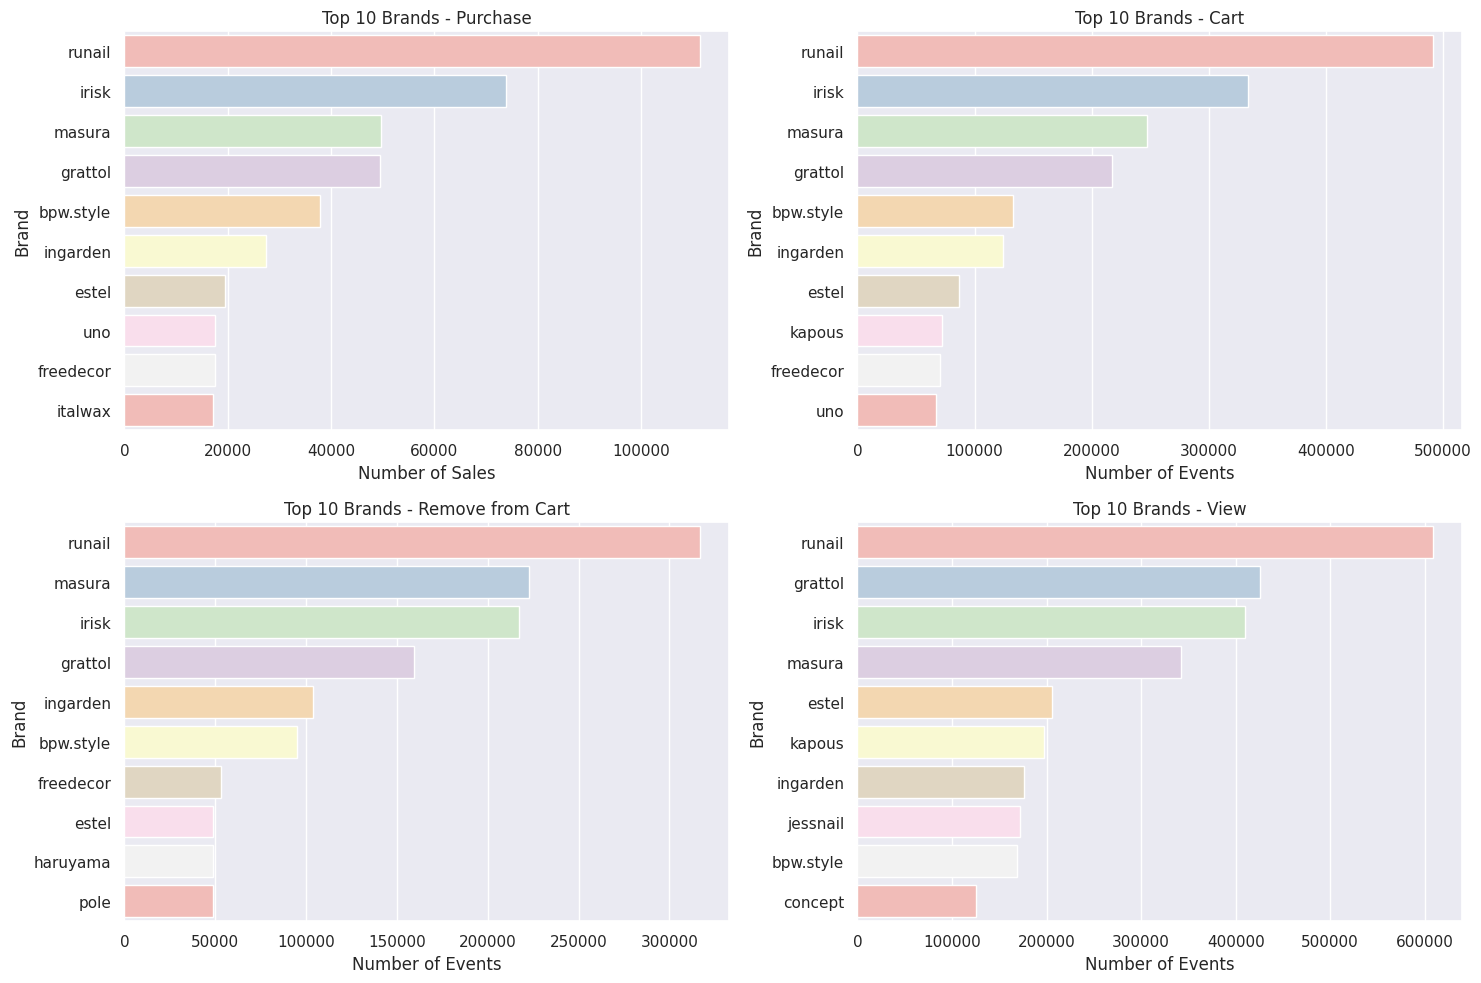

In [ ]:
# Task 1: Top 10 event products/brands
# Filter the DataFrame for the specified event types
event_types = ['purchase', 'cart', 'remove_from_cart', 'view']
filtered_df = df[df['event_type'].isin(event_types)]

# Get the top 10 brands for each event type
top_10_brands_purchase = filtered_df[filtered_df['event_type'] == 'purchase']['brand'].value_counts().head(10)
top_10_brands_cart = filtered_df[filtered_df['event_type'] == 'cart']['brand'].value_counts().head(10)
top_10_brands_remove_from_cart = filtered_df[filtered_df['event_type'] == 'remove_from_cart']['brand'].value_counts().head(10)
top_10_brands_view = filtered_df[filtered_df['event_type'] == 'view']['brand'].value_counts().head(10)

# Visualize top 10 brands for each event type
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Purchase
sns.barplot(x=top_10_brands_purchase.values, y=top_10_brands_purchase.index, ax=axes[0, 0], palette='Pastel1')
axes[0, 0].set_xlabel('Number of Sales')
axes[0, 0].set_ylabel('Brand')
axes[0, 0].set_title('Top 10 Brands - Purchase')

# Cart
sns.barplot(x=top_10_brands_cart.values, y=top_10_brands_cart.index, ax=axes[0, 1], palette='Pastel1')
axes[0, 1].set_xlabel('Number of Events')
axes[0, 1].set_ylabel('Brand')
axes[0, 1].set_title('Top 10 Brands - Cart')

# Remove from Cart
sns.barplot(x=top_10_brands_remove_from_cart.values, y=top_10_brands_remove_from_cart.index, ax=axes[1, 0], palette='Pastel1')
axes[1, 0].set_xlabel('Number of Events')
axes[1, 0].set_ylabel('Brand')
axes[1, 0].set_title('Top 10 Brands - Remove from Cart')

# View
sns.barplot(x=top_10_brands_view.values, y=top_10_brands_view.index, ax=axes[1, 1], palette='Pastel1')
axes[1, 1].set_xlabel('Number of Events')
axes[1, 1].set_ylabel('Brand')
axes[1, 1].set_title('Top 10 Brands - View')

plt.tight_layout()
plt.show()


In [ ]:
print('runail: ', df[df['brand'] == 'runail']["price"].head(1))
print('masura: ', df[df['brand'] == 'masura']["price"].head(1))
print('irisk: ', df[df['brand'] == 'irisk']["price"].head(1))
print('grattol: ', df[df['brand'] == 'grattol']["price"].head(1))
print('ingarden: ', df[df['brand'] == 'ingarden']["price"].head(1))
print('bpw.style: ', df[df['brand'] == 'bpw.style']["price"].head(1))
print('freedecor: ', df[df['brand'] == 'freedecor']["price"].head(1))
print('estel: ', df[df['brand'] == 'estel']["price"].head(1))
print('haruyama: ', df[df['brand'] == 'haruyama']["price"].head(1))
print('pole: ', df[df['brand'] == 'pole']["price"].head(1))
print('kapous: ', df[df['brand'] == 'kapous']["price"].head(1))
print('uno: ', df[df['brand'] == 'uno']["price"].head(1))

print('\nrunail: 2.62', 'masura: 2.37', 'irisk: 0.6')

runail:  0    2.62
Name: price, dtype: float64
masura:  20    2.37
Name: price, dtype: float64
irisk:  12    0.6
Name: price, dtype: float64
grattol:  54    10.32
Name: price, dtype: float64
ingarden:  28    0.79
Name: price, dtype: float64
bpw.style:  25    1.9
Name: price, dtype: float64
freedecor:  356    0.79
Name: price, dtype: float64
estel:  26    7.3
Name: price, dtype: float64
haruyama:  153    1.98
Name: price, dtype: float64
pole:  83    0.7
Name: price, dtype: float64
kapous:  6    4.75
Name: price, dtype: float64
uno:  187    10.32
Name: price, dtype: float64

runail: 2.62 masura: 2.37 irisk: 0.6


Based on the provided information, the top 10 brands are analyzed based on different event types. The brand "Runail" (nail polish) stands out as the most popular brand across various event types. Here is the breakdown of the popular brands for each event type:

Purchase:
1. Runail
2. Irisk
3. Masura

Add to Cart:
1. Runail
2. Irisk
3. Masura

Remove from Cart:
1. Runail
2. Masura
3. Irisk

View:
1. Runail
2. Grattol
3. Irisk

These rankings allow us to identify the popular brands based on specific event types. Runail emerges as the leading brand in terms of purchases, additions to the cart, removals from the cart, and views. Irisk and Masura also appear among the top brands for purchases and additions to the cart, while Grattol is the second most viewed brand.


Deep dive, why these are in top 3 products: because they're popular brand in Russia and relative cheap products (runail: 2.62 masura: 2.37 irisk: 0.6)

### Funnel Analysis (Customer Journey)

To visualize the customer journey from viewing a product to adding it to the cart and finally making a purchase, a funneling analysis can be used. Funneling analysis provides a visual representation of the progression of customers through different stages of the conversion process. Here is an overview of the customer journey funnel:

1. View Product:
   - This is the initial stage where customers view different products.

2. Add to Cart:
   - Customers who show interest in a product proceed to add it to their cart.

3. Purchase:
   - Finally, customers who have added products to their cart complete the purchase.

By visualizing this funneling analysis, we can gain insights into the conversion rates at each stage and identify potential areas for improvement in the customer journey.

In [ ]:
# Task 2: Funneling analysis
import plotly.graph_objects as go
data_funnel=df[df['event_type']!='remove_from_cart'].groupby(['event_type'],as_index=False)['event_time'].count()
data_funnel.columns=['event_type','# events']
data_funnel.sort_values('# events', inplace=True,ascending=False)
data_funnel.reset_index(drop=True,inplace=True)
data_funnel['percent']=data_funnel['# events']/(data_funnel['# events'][0].sum())*100
data_funnel

#plotly to visualise funnel
fig = go.Figure(go.Funnel(
    y = data_funnel["event_type"],
    x = data_funnel["# events"],
    customdata=data_funnel["percent"],
    texttemplate= "<b>%{label}: </B>%{value:.2s}"+"<br><b>% of Total:</b> %{customdata:.2f}%",
    textposition='inside',
    marker = {"color": ["lightyellow", "lightsalmon", "tan"]}
    ))
fig.update_yaxes(visible=False)
fig.update_layout(template='simple_white',     
                  title={'xanchor': 'center',
                         'yanchor': 'top',        
                         'y':0.9,
                         'x':0.5,
                         'text':"Customer Funnel for Purchase Journey"})
fig.show()




By conducting a funneling analysis on the customer journey in this e-commerce, we can observe the progression of customers through various stages. Here are the key findings from the analysis:

1. View Product:
   - The initial stage of the customer journey involves customers viewing products. In this case, there were a total of 9.7 million (100%) views on all products.

2. Add to Cart:
   - Out of those who viewed the products, 5.8 million customers (59.73%) proceeded to add items to their carts. This indicates a significant drop-off from the initial view stage.

3. Purchase:
   - Among the customers who added items to their carts, only 1.3 million (13.33%) completed the purchase. This highlights a further reduction in the conversion rate from the add to cart stage to the final purchase.

These findings provide valuable insights into the customer journey within the e-commerce platform. The funneling analysis illustrates the drop-off rates at each stage, indicating potential areas for improvement in the conversion process. By identifying and addressing bottlenecks, such as optimizing the cart-to-purchase experience, the e-commerce business can work towards increasing conversions and maximizing customer satisfaction.

Deep dive: Why is the drop significant in the "Add to Cart" stage? User behavior indicates that they primarily view products without showing much interest in adding them to the cart. Notably, the brand "Gratol" ranks second in terms of views but is placed fourth in the cart ranking.

Furthermore, why does the drop in the "Purchase" stage also show significance? Many products, particularly the top three added to the cart (Runail, Irisk, Masura), are removed from the cart at a significant rate, approximately half of them.

Explanation: The observed trends in user behavior raise concerns about the conversion rate from the "View" stage to the "Add to Cart" stage. Users seem more inclined to browse products without taking the next step of adding them to their cart. This indicates a potential issue with product engagement or lack of compelling incentives for users to proceed with the purchasing process.


### Event Time Analysis

<Axes: xlabel='event_time', ylabel='average spend/customer ($)'>

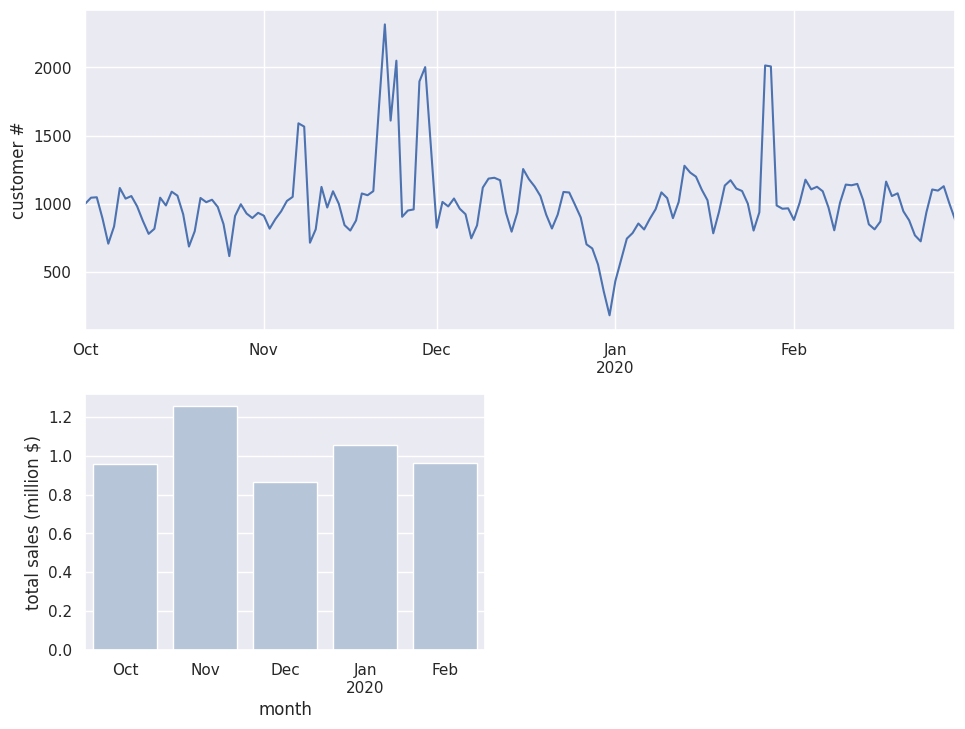

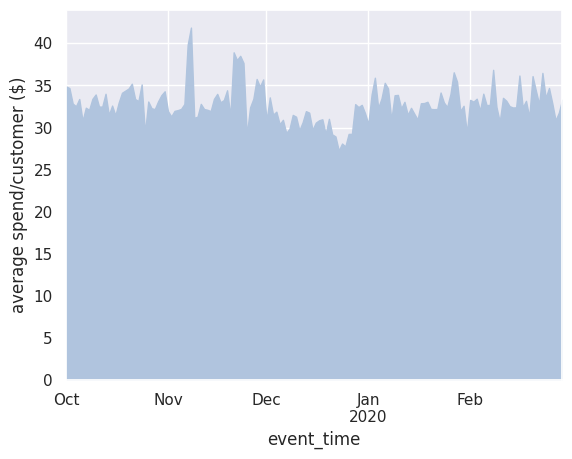

In [ ]:
# initial data exploration

plt.figure(figsize=(10,8))

# plot the number of customers each day 
plt.axes([0.08, 0.4, 0.87, 0.4])
df_sales_n_user=df_sales.resample("D",on='event_time')['user_id'].nunique()
df_sales_n_user.plot(kind='line')
plt.xlabel('')
plt.ylabel('customer #')

# plot total sales/month 
plt.axes([0.08,0,0.4,0.32])
a=df_sales.resample('M',on='event_time')['price'].sum().to_frame()
a['month']=['Oct','Nov','Dec',"Jan\n2020", "Feb"]
a['price']=a['price']/1000000
sns.barplot(x='month',y='price',data=a,color="lightsteelblue")
plt.xlabel('month')
plt.ylabel('total sales (million $)')

# plot average spend/customer
fig, ax = plt.subplots()
ax.set_xlabel('date')
ax.set_ylabel('average spend/customer ($)')

df_sales_p_day = df_sales.resample('D', on='event_time')['price'].sum()
df_sales_spent = df_sales_p_day / df_sales_n_user
df_sales_spent.plot(kind='area', color="lightsteelblue", alpha=1, linestyle='None', ax=ax)

The time series analysis showed that:

**(Graph 1)** In November 2019 (possibly during Thanksgiving) and the end of January 2020 (likely during a sales event), the customer count experienced significant spikes. However, there was a notable drop in customer numbers on New Year's Eve, which could be attributed to system downtime or other factors.

**(Graph 2)** Furthermore, sales exhibited an upward trend, increasing from approximately 0.95 million dollars in October 2019 to around 1.3 million dollars in November 2019. Sales then declined to approximately 0.85 million dollars in December 2019 but stabilized at around 1 million dollars per month in the subsequent two months.

**(Graph 3)** Interestingly, the average spend per customer showed minimal changes over the course of five months, indicating relatively consistent purchasing behavior.

# Modelling

In order to optimize our marketing campaigns, I chose to employ the **RFM (Recency, Frequency, Monetary Value)** model, which is both simple and highly effective. The RFM analysis is based on three essential factors that help us understand customer behavior and preferences.

The first factor, **Recency, evaluates how recently a customer made a purchase**. By analyzing the time elapsed since their last purchase, we can identify customers who have engaged with our business recently. These customers are more likely to be receptive to marketing efforts and may represent an opportunity for upselling or cross-selling.

The second factor, **Frequency, measures how often a customer makes purchases**. Understanding the frequency of customer transactions allows us to segment them based on their buying habits and loyalty. Customers with higher purchase frequencies are valuable as they contribute to our revenue consistently. Targeting them with personalized offers or loyalty programs can help maintain their loyalty and encourage repeat purchases.

The third factor, **Monetary Value, focuses on the amount of money a customer spends on their purchases**. This factor helps us identify high-value customers who make significant contributions to our revenue. By segmenting customers based on their monetary value, we can tailor specific marketing campaigns to reward their loyalty or entice them with premium products or services.

Once we have selected the relevant rows and columns from our dataset, **we proceed to remove any duplicate records** that could skew our analysis and produce misleading results. **Additionally, performing necessary data type conversions** ensures that the data is in the appropriate format for accurate analysis. For example, converting dates to a standardized format or transforming currency values into a consistent currency.

By leveraging the power of the RFM model and following these data preparation steps, we can effectively segment our customer base to optimize our marketing campaigns. This targeted approach enables us to deliver personalized messages, offers, and experiences that resonate with each customer segment, ultimately driving customer satisfaction, loyalty, and business growth.

In [ ]:
# group the data by "user_id", and calcualte each customer's recency, frequency, and monetary value

# step 1: calculate "Recency", set Feb 2020 as the reference month, and use "month" as the unit
#d={"Oct":4,"Nov":3,"Dec":2,"Jan":1,"Feb":0}
#df_sales.loc[:,'Recency']=df_sales['month'].map(d)
df_sales["event_time"] = pd.to_datetime(df_sales["event_time"])
df_sales.loc[:,'Recency'] = (df_sales["event_time"].max() - df_sales["event_time"]).dt.days
df_R=df_sales.groupby('user_id')['Recency'].min().reset_index().rename(columns={"0":"Recency"})

# step 2: calculate "Frequency"
df_F=df_sales.groupby('user_id')['event_type'].count().reset_index().rename(columns={"event_type":"Frequency"})

# step 3: calculate "Monetary"
df_M=df_sales.groupby('user_id')['price'].sum().reset_index().rename(columns={"price":"Monetary"})

# step 4: merge "Recency", "Frequency", and "Monetary"
df_RF=pd.merge(df_R,df_F,on='user_id')
df_RFM=pd.merge(df_RF,df_M,on='user_id')

# step 5: remove outliers before K-Means clustering
conditions=np.abs(stats.zscore(df_RFM.loc[:,['Recency','Frequency','Monetary']]) < 3).all(axis=1)
df_RFM2=df_RFM.loc[conditions,:]

df_RFM2.head(3)


,user_id,Recency,Frequency,Monetary
0,9794320,96,2,7.72
1,10079204,115,2,25.81
2,10280338,10,19,63.29


Continuing the analysis, I proceeded to **group the data by user_id and performed calculations to determine each customer's Recency, Frequency, and Monetary Value**.

**Recency was measured by determining the number of days until the latest event_time, considering it to be February 29, 2020.** This metric reflected how long it had been since the customer's last purchase.

**Frequency was assessed by evaluating how often the customer made purchases between October 2019 and February 2020.** This metric provided insights into the customer's purchasing habits during that period.

**Monetary Value was determined by calculating the total amount spent by each customer from October 2019 to February 2020.** This metric quantified the customer's overall spending contribution during the analyzed timeframe.

To ensure the accuracy of the analysis, **I removed outliers from the dataset before proceeding with clustering**. This step helped eliminate any extreme or atypical values that could skew the results and provided a more reliable basis for the clustering process.

By performing these calculations and filtering out outliers, we were able to prepare the data for subsequent clustering analysis, enabling us to identify distinct customer segments based on their Recency, Frequency, and Monetary Value.

In [ ]:
print("max Recency: ", df_RFM2['Recency'].max())
print("max Frequency: ",df_RFM2['Frequency'].max())
print("max Monetary: ",df_RFM2['Monetary'].max())

max Recency:  151
max Frequency:  41
max Monetary:  251.98000000000002


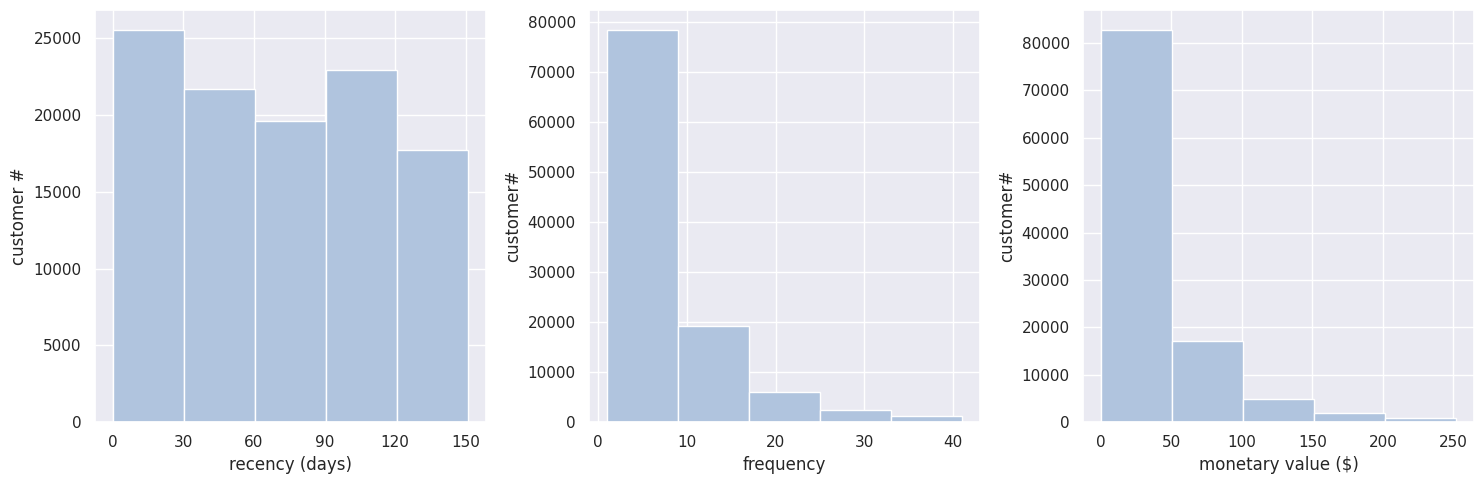

In [ ]:
# visualize the distribution of "Recency", "Frequency", and "Monetary"
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

# plot "Recency"
ax1.hist(df_RFM2['Recency'],bins=5,color='lightsteelblue')
ax1.set_xticks(np.arange(0,151,30))
ax1.set_xlabel('recency (days)')
ax1.set_ylabel('customer #')

# plot "Frequency"
ax2.hist(df_RFM2['Frequency'],bins=5,color='lightsteelblue')
ax2.set_xlabel('frequency')
ax2.set_ylabel('customer#')

# plot "Monetary"
ax3.hist(df_RFM2['Monetary'],bins=5,color='lightsteelblue')
ax3.set_xlabel('monetary value ($)')
ax3.set_ylabel('customer#')

plt.tight_layout()

Upon initial examination of the RFM data, several key findings emerged:

(1) **Recency**: The distribution of customers along the recency curve **appeared to be relatively even, with a majority of customers exhibiting low recency**. This suggests that most customers had made recent purchases.

(2) **Frequency**: The analysis revealed that the **majority of customers made fewer than 10 purchases** during the analyzed period. This indicates that customers, on average, did not make frequent transactions.

(3) **Monetary Value**: Most customers were found to have **spent less than 100 dollars in total**. This suggests that the majority of customers had relatively lower spending levels.

## Customer Segmentation by RFM-Based K-Means Clustering

In traditional RFM models, customers are typically assigned individual scores for each RFM factor, which are later combined for segmentation purposes. However, drawing inspiration from Chen (2012), **I opted to perform RFM analysis using K-Means clustering**. To begin this process, I undertook two initial steps.

**Firstly, I standardized the data**. Standardization involves transforming the RFM variables to have a mean of 0 and a standard deviation of 1. This ensures that all factors are on the same scale (0-1), preventing any particular RFM component from dominating the clustering process.

**Secondly, I employed the elbow method** to determine the optimal number of clusters for the K-Means algorithm. The elbow method involves running K-Means clustering with varying numbers of clusters and evaluating the sum of squared distances within each cluster. By plotting the resulting values and identifying the "elbow" point on the graph, I was able to determine the optimal number of clusters to use in the subsequent analysis.

By utilizing K-Means clustering and following these initial steps of data standardization and determining the optimal number of clusters, I set the stage for segmenting customers based on their RFM characteristics. This approach allows for a more data-driven and nuanced understanding of customer groups, facilitating targeted marketing strategies tailored to the specific needs and behaviors of each segment.

### Elbow Method

The Elbow Method is a technique used in data analysis and machine learning for determining the optimal number of clusters in a dataset. It is commonly applied in clustering algorithms, such as K-means clustering. The method gets its name from the shape of the plot that resembles an elbow.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

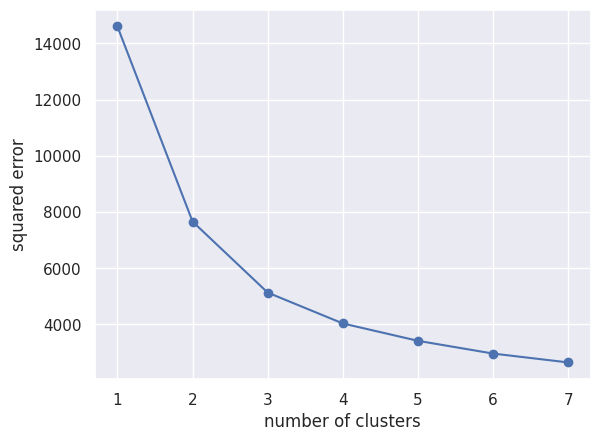

In [ ]:
# k-means clustering: using recency, frequency, and monetary as clustering variables

from sklearn.preprocessing import MinMaxScaler

# step 1: standardize data
df_RFM3=df_RFM2.drop(columns=['user_id'])
scaler = MinMaxScaler()
X = scaler.fit_transform(df_RFM3)

# step 2: find the optimal number of clusters
SSE=[]
for i in range(1,8,1):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(X)
    SSE.append(kmeans.inertia_)
sns.set()
plt.plot(range(1,8,1),SSE,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('squared error');

After applying the Elbow Method to the dataset and plotting the results, we can observe that the plot exhibits an elbow shape. The elbow point on the plot indicates a significant change in the rate of decrease in the sum of squared distances (SSD) as the number of clusters increases. It means that as we increase the number of clusters in the K-means clustering algorithm, the SSD (which measures how close the data points are to their respective cluster centers) decreases.

However, at a certain point, adding more clusters does not lead to a significant decrease in the SSD. The elbow point on the plot represents that specific number of clusters where the rate of decrease in the SSD starts to level off or slow down significantly. It is called the elbow point because the plot often shows a bend or elbow-like shape at that specific value of clusters.

In this particular case, the elbow point occurs at a value of 3 on the x-axis. This suggests that using 3 clusters would be an appropriate choice for the dataset when applying the K-means clustering algorithm. By selecting 3 clusters, we aim to strike a balance between capturing the underlying patterns in the data while keeping the model relatively simple.

### Silhouette Score

By calculating the silhouette score for the dataset using the K-means clustering algorithm, we can assess the quality of clustering. The silhouette score measures how well each data point fits its assigned cluster compared to other clusters. A higher silhouette score indicates better-defined and well-separated clusters.

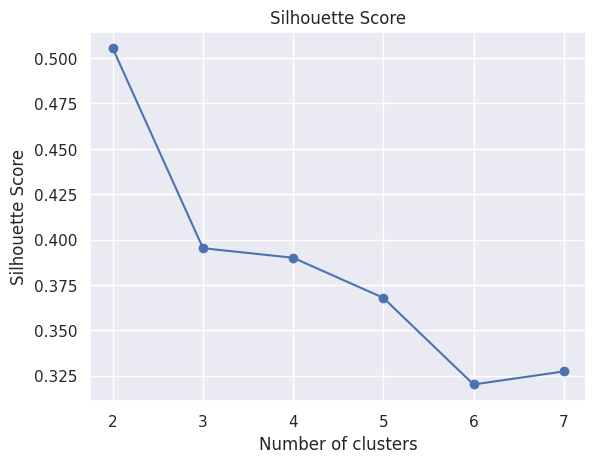

In [ ]:
# step 2: find the optimal number of clusters
from joblib import Parallel, delayed

# Define a function to compute silhouette scores for a given number of clusters
def compute_silhouette_score(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    labels = kmeans.labels_
    return silhouette_score(X, labels)

# Parallelize the computation for different numbers of clusters
num_clusters = range(2, 8)
silhouette_scores = Parallel(n_jobs=-1)(delayed(compute_silhouette_score)(n) for n in num_clusters)

# Plot the silhouette scores
plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

In this case, the silhouette score for the dataset with 3 clusters is approximately 0.39. This score suggests that the clusters are reasonably distinct and well-separated, as a score closer to 1 indicates better clustering quality. Therefore, using 3 clusters appears to be a suitable choice based on the silhouette score evaluation.

To calculate the silhouette score and determine the elbow point, you can follow these steps:

1. Silhouette Score:
   - Apply the K-means clustering algorithm to your dataset with different values of k (number of clusters).
   - For each value of k, calculate the average silhouette score for all data points.
   - The silhouette score for a single data point is computed by finding the average distance between the data point and all other points within the same cluster (a) and the average distance between the data point and all points in the nearest neighboring cluster (b). The silhouette score for the data point is then given by (b - a) / max(a, b).
   - Calculate the average silhouette score for all data points in the dataset, and repeat this process for each value of k.
   - Select the value of k that corresponds to the highest average silhouette score, as it indicates the best number of clusters for the dataset.

2. Elbow Method:
   - Apply the K-means clustering algorithm to your dataset with different values of k (number of clusters).
   - For each value of k, calculate the sum of squared distances (SSD) between each data point and its nearest centroid.
   - Plot the resulting SSD values for each value of k.
   - Analyze the plot and look for the "elbow" or bend point where the SSD values start to level off.
   - The number of clusters at the elbow point is considered the optimal number of clusters for the dataset.

Both the silhouette score and the elbow method provide insights into finding the optimal number of clusters. The silhouette score focuses on the quality and separation of clusters, while the elbow method evaluates the rate of decrease in the SSD. Combining these techniques can help you make an informed decision about the appropriate number of clusters for your data.

### Radar Map

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



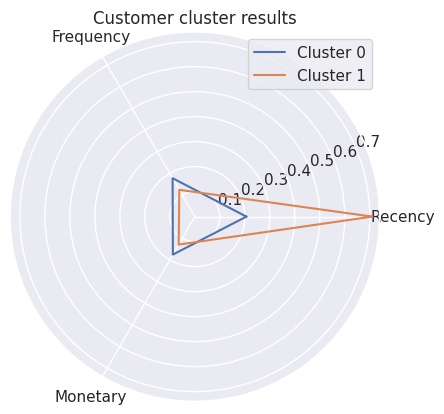

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



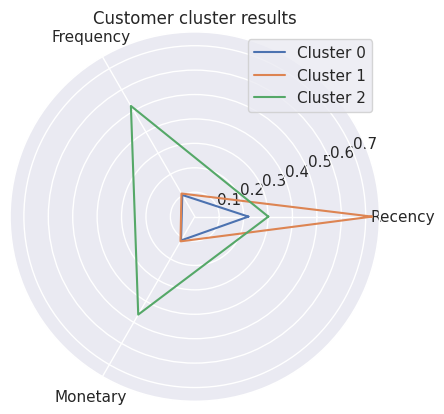

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



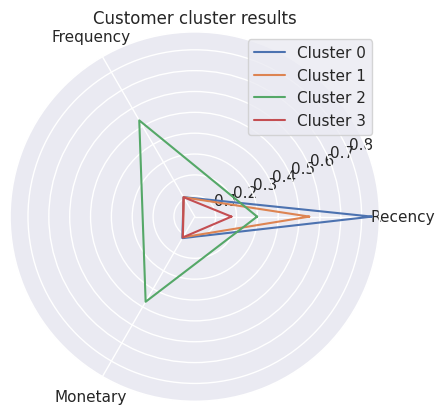

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



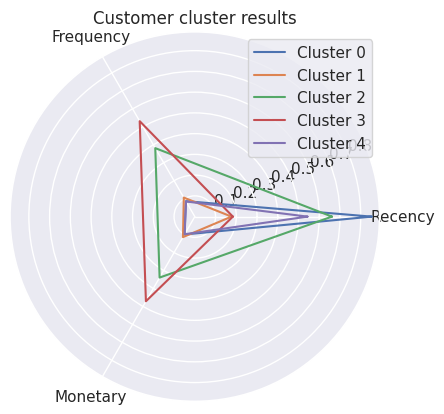

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



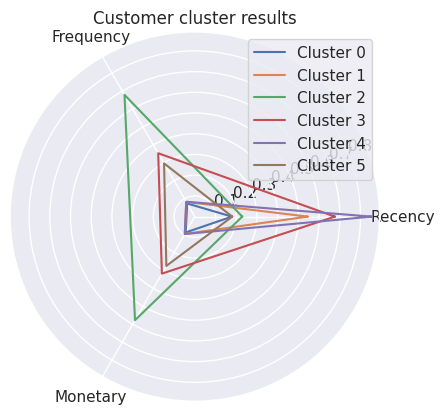

In [ ]:

k = list(range(2,7))
column_names = df_RFM3.columns.tolist()

for i in k:
  kmeans = KMeans(n_clusters = i,random_state=0)
  fit_kmeans = kmeans.fit(X)
  centers = kmeans.cluster_centers_
  center_column = column_names

  plt.figure()

#   plt.rcParams['font.sans-serif'] = 'SimHei'
  plt.rcParams['axes.unicode_minus'] = False


  datalength = X.shape[1]
  angle = np.linspace(0, 2 * np.pi, datalength, endpoint=False)
  angle = np.concatenate((angle, [angle[0]]), axis=0)

  centers = np.concatenate((centers, centers[:, 0:1]), axis=1)

  for i in range(centers.shape[0]):
    plt.polar(angle, centers[i, :])
                            
  plt.title('Customer cluster results')

  plt.xticks(angle[:-1], center_column)

  plt.legend(['Cluster 0','Cluster 1','Cluster 2','Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], loc='best')

  plt.show()


Based on the graph above, I decided to group our customers into 3 clusters by K-Means.

### 3D Visualization of the 3 clusters

RFM (Recency, Frequency, Monetary) is a commonly used method for customer segmentation. To visualize the segmentation of customers into three groups based on RFM features, we can use a 3D scatter plot. The three axes will represent the RFM dimensions, and each point in the plot will represent an individual customer.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



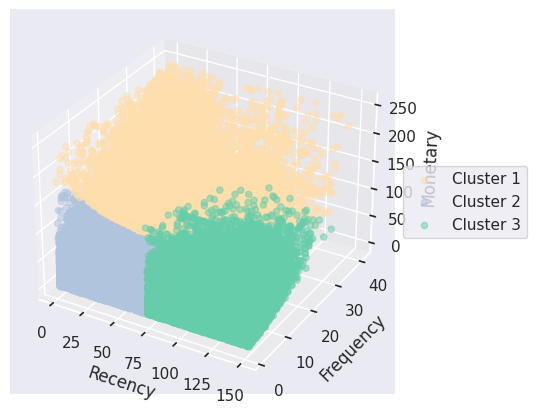

In [ ]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 3: group customers into 3 clusters
random.seed(8)
km=KMeans(n_clusters=3,random_state=0)
km.fit(X)
random.seed(8)
pred=km.predict(X)
df_RFM2=df_RFM2.assign(clusters=pred)

# step 4: visualize the 3 clusters

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# data preparation
df_RFM2['clusters'] = pred
df_RFM2['clusters'] = df_RFM2['clusters'].replace({2: 'Cluster 1', 0: 'Cluster 2', 1: 'Cluster 3'})
cluster_orders = ['Cluster 1', 'Cluster 2', 'Cluster 3']
cluster_colors = ['navajowhite', 'lightsteelblue', 'mediumaquamarine', 'thistle']
# 3D scatter plot
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(cluster_orders)):
    x = df_RFM2.loc[df_RFM2['clusters']==cluster_orders[i], 'Recency']
    y = df_RFM2.loc[df_RFM2['clusters']==cluster_orders[i], 'Frequency']
    z = df_RFM2.loc[df_RFM2['clusters']==cluster_orders[i], 'Monetary']
    ax.scatter(x, y, z, c=cluster_colors[i], marker='o', alpha=0.5, label=cluster_orders[i])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



### Group customers into 3 clusters

In [ ]:
# step 3: group customers into 3 clusters
random.seed(8)
km=KMeans(n_clusters=3,random_state=0)
km.fit(X)
random.seed(8)
pred=km.predict(X)
df_RFM2=df_RFM2.assign(clusters=pred)

# step 4_1: data preparation
R=[]
F=[]
M=[]
mycolors=['lightsteelblue','mediumaquamarine','thistle']
cluster_orders=[2,0,1]
for i in [0,1,2]:
    R.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Recency'].values.tolist())
    F.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Frequency'].values.tolist())
    M.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Monetary'].values.tolist())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



         segments  Recency  Frequency  Monetary  MonetarySum   size  \
0         At-Risk    108.0        4.0    22.380   1509020.92  50985   
1  Loyal Customer     38.0       21.0   107.310   1310103.28  11204   
2   New Customers     32.0        4.0    22.615   1292903.42  45318   

   Sales/Customer  
0              30  
1             117  
2              29  


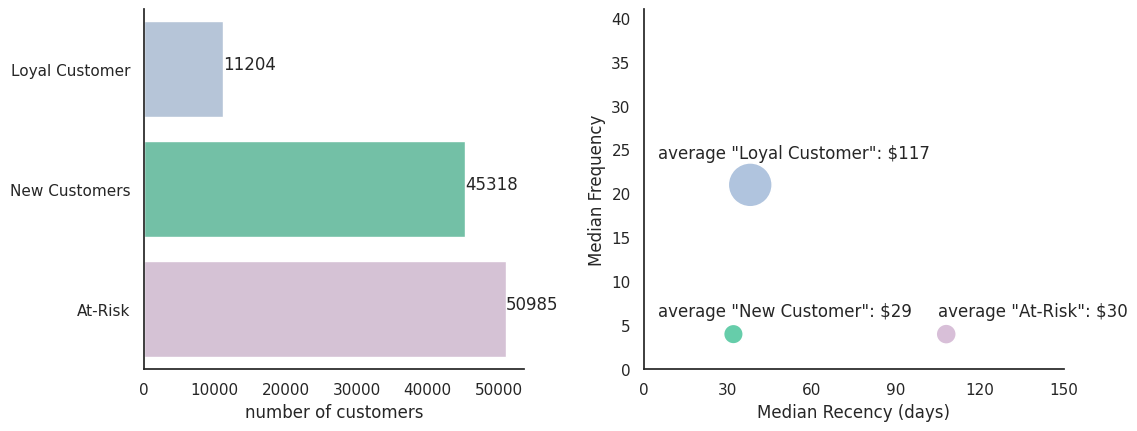

In [ ]:
# replace k-means cluster names with more meaningful names
d1={0:"New Customers", 2:"Loyal Customer", 1: "At-Risk"}
df_RFM2.loc[:,"segments"]=df_RFM2.loc[:,"clusters"].map(d1)

# calculate the number of customers, median recency, median frequency, 
# and average customer spend in each customer segment
df_RFM3=df_RFM2.groupby('segments').agg(Recency=('Recency',np.median),Frequency=('Frequency',np.median),Monetary=('Monetary',np.median),MonetarySum=('Monetary',np.sum),size=("clusters",'size'))
df_RFM3.loc[:,'Sales/Customer']=round(df_RFM3.loc[:,'MonetarySum']/df_RFM3.loc[:,'size'])
df_RFM3=df_RFM3.astype({'Sales/Customer':int}).reset_index()
print(df_RFM3)

# visualize
plt.figure(figsize=(10,4))
seg_names=['Loyal Customer','New Customers','At-Risk']

# plot the number of customers in each segment
sns.set_style("white")
plt.axes([0, 0, 0.38, 0.9])
seg=df_RFM2.groupby('segments').size().to_frame().rename(columns={0:'number of customers'}).reset_index()
sns.barplot(x='number of customers',y='segments',data=seg,order=seg_names,palette=mycolors)
for i in [0,1,2]:
    number = seg.loc[seg.segments==seg_names[i], 'number of customers'].item()
    x_pos=round(number,-2)
    plt.text(x_pos,i,number)
plt.ylabel("")
sns.despine()

# plot recency, frequency, and average spend/customer of the 4 segments
plt.axes([0.5,0,0.42,0.9])
sns.scatterplot(x='Recency',y='Frequency',hue='segments',hue_order=seg_names,palette=mycolors,size='Sales/Customer',sizes=(200,1000),legend=False,data=df_RFM3)
plt.ylim(0,41)
plt.xticks(np.arange(0,151,30))
plt.text(5,24,'average "Loyal Customer": $117')
plt.text(5,6,'average "New Customer": $29')
plt.text(105,6,'average "At-Risk": $30')
plt.xlabel('Median Recency (days)')
plt.ylabel('Median Frequency')/Screenshot 2023-06-02 at 18.20.16.png
sns.despine()



Recency: How recently a customer made a purchase.

Frequency: How often a customer makes purchases.

Monetary: How much money a customer spends on purchases.



# Summary

Taken together, our customers were grouped into 3 segments:

        (1) Loyal Customers: These customers purchased very often and spent the highest amount of money. They shopped from Oct 2019 to Feb 2020 with a medium recency.

        (2) New Customers: We had such a large group of new customers. They started shopping very recently and as a result, they didn’t make purchases often but they spend reasonable money.

        (3) At-Risk: This is the largest-sized group! These customers have high recency, low frequency, and low monetary.

Business insights:

1. It is evident that we need to carefully manage the inventory of Runail, Irisk, and Masura in our monthly sales. These brands show consistent demand and require sufficient stock levels to meet customer expectations and prevent stockouts.

2. The observed trends suggest a potential issue with product engagement or a lack of compelling incentives for users to complete the purchasing process. To address this, we should focus on improving the user experience, optimizing product descriptions, and implementing effective marketing strategies to encourage users to proceed with their purchases.

3. To convert new customers into loyal ones, we can modify their behavior by implementing a cluster-based approach and offering incentives such as coupons, vouchers, stamps, or a loyalty program. This will allow users to have a positive first-time experience with our products and create a pampering environment that entices them to make repeat purchases.

4. To transform at-risk customers into "new customers" and prevent them from becoming at-risk, we should offer special brands or exclusive discounts to this customer segment. This approach aims to incentivize at-risk customers to return and make a purchase, while also preventing new customers from falling into the at-risk category.

By implementing these strategies, we can improve customer engagement, foster loyalty, and maximize customer retention, ultimately driving business growth and profitability.